<h1 style="color:C0504D;">ПРОЕКТ: Восстановление золота из руды</h1>

<div style="background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    <div style="color: black;">
        <p>В распоряжении есть данные с параметрами добычи и очистки, компания разрабатывает решения для эффективной
            работы
            промышленных предприятий.</p>
        <p><b>Цель данного проекта</b> - Необходимо построить модель машинного обучения, которая поможет предсказать
            коэффициент восстановления золота из золотосодержащей руды.</p>
    </div>
    <div style="color: C0504D; font-weight: bold;">
        <ol>
            <li>Загрузить и подготовить данные:
            <ul style="color: black; font-weight: normal;" type="disc">
                <li>Проверить, что эффективность обогащения рассчитана правильно;</li>
                <li>Проверить состав предоставленных выборок;</li>
                <li>Проверить данные на наличие пропусков;</li>
                <li>Провести восстановление пропусков;</li>
                <li>Проанализировать результаты.</li>
            </ul>
            <li>Проанализировать данные:
            <ul style="color: black; font-weight: normal;" type="disc">
                <li>Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки;</li>
                <li>Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках;</li>
                <li>Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и
                    финальном
                    концентратах;</li>
                <li>Сделать выводы.</li>
            </ul>
            <li>Обучить модель и выбрать лучшую:
            <ul style="color: black; font-weight: normal;" type="disc">
                <li>Напишите функцию для вычисления итоговой <b>sMAPE</b>;</li>
                <li>Обучите разные модели;</li>
                <li>Подобрать для моделей оптимальные гиперпараметры;</li>
                <li>Оценить качество моделей кросс-валидацией;</li>
                <li>Выбрать лучшую модель</li>
                <li>Сделать выводы.</li>
            </ul>
            <li>Тестирование лучшей модели:
            <ul style="color: black; font-weight: normal;" type="disc">
                <li>Проверить модель на тестовой выборке;</li>
                <li>Проанализировать предсказания выбранной модели;</li>
                <li>Написать выводы и обосновать выбор.</li>
            </ul>
    </div>
</div>

In [1]:
# библиотеки
import re
import pandas as pd 
import numpy as np
import seaborn as sns
import warnings 
from matplotlib import pyplot as plt
from time import time

# обработка
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# модели
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

# метрики
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.impute import KNNImputer

# настройки и параметры
from tqdm import notebook
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')


<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    создам стиль для отображения табличных данных
</p>

In [2]:
cell_hover     = {'selector': 'td:hover',
                  'props'   : [('background', '#9E4447'), 
                               ('color', '#ffffff')]}           # формат выделенной ячейки

row_hover      = {'selector': 'tr:hover',
                  'props'   : [('background', '#808080'), 
                               ('color', '#ffffff')]}           # формат выделенной строки

color_row_even = {'selector': 'tr:nth-of-type(even)',
                  'props'   : [('background', '#D9D9D9'),
                               ('color', 'black')]}             # формат нечетных строк

color_row_odd  = {'selector': 'tr:nth-of-type(odd)',
                  'props'   : [('background', '#ffffff'),
                               ('color', '#363636')]}           # формат четных строк

index_names    = {'selector': 'th',
                  'props'   : [('background', '#363636'), 
                               ('color', '#ffffff'),  
                               ('text-align','center')]}        # формат заголовка и индекса

border_inner   = {'selector': 'td',
                  'props'   : [('border','1px dashed #363636')]}# формат границы таблицы

border_outer   = {'selector': '',
                  'props'   : [('border','2px solid #363636')]} # формат границы таблицы

caption        = {'selector': 'caption',
                  'props'   : [('color', '#363636'), 
                               ('font-size', '15px')]}

# передаю в переменную для дальнейшего использования
styler = [cell_hover, color_row_even, color_row_odd, index_names, row_hover, border_inner, border_outer, caption]

<h2 style="color:C0504D;">Загрузка и подготовка данных</h2>

<h3 style="color:C0504D;">Загрузка данных</h3>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Загрузим данные и познакомимся с их содержимым
</p>

In [3]:
try:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test  = pd.read_csv('/datasets/gold_recovery_test_new.csv ')
    data_full  = pd.read_csv('/datasets/gold_recovery_full_new.csv .csv')
except:
    data_train = pd.read_csv('gold_recovery_train_new.csv')
    data_test  = pd.read_csv('gold_recovery_test_new.csv')
    data_full  = pd.read_csv('gold_recovery_full_new.csv')

In [4]:
data_flow      = [data_train, data_test, data_full]
data_flow_name = ['data_train', 'data_test', 'data_full']

STAGE  = ['rougher', 'primary_cleaner', 'final', 'secondary_cleaner']
METAL  = ['ag', 'au', 'pb', 'sol']
TYPE   = ['calculation', 'input', 'state', 'output']
SAMPLE = [data_train, data_test, data_full]
TARGET = ['rougher_output_recovery', 'final_output_recovery']
RANDOM = 1123581321

In [5]:
for name, data in enumerate(data_flow):
    display(data.head(5).style\
                        .set_caption(f'Набор данных {data_flow_name[name]}')\
                        .set_table_styles(styler))
    display(data.info())
    print('='*100)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.250000,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.250000,1.002663,8.55

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

None

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.250000,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.250000,1.002663,8.55

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


None

<div style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    <p>
        При знакомстве с выборками были обнаружены следующие проблемы:
    </p>
    <ul>
        <li>Наличие пропусков;
        <li>Формат записи признаков через точку;
        <li>Отсутствие признаков в выборке data_test;
        <li>Признак date, необходимо задать тип времени и принять его как индекс во всех датафрейм.
    </ul>

<h3 style="color:C0504D;">Изменение типа данных</h3>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Все признаки в датафреймах являются числовыми, кроме признака date, я думаю что это ключевой признак по которому
    необходимо будет обращаться из одной выборки в другую, для этого необходимо изменить тип данных и задать его как
    индекс во всех выборках. Для этого я подготовлю функцию, которая будет на вход принимать признак, менять формат на
    временной и задаст его как индекс
</p>

In [6]:
def index_to_date(data, column_name):
    data[column_name] = pd.to_datetime(data[column_name], format="%Y-%m-%d %H:%M:%S")
    data = data.set_index(column_name)
    return data

In [7]:
data_train = index_to_date(data_train, 'date')
data_test  = index_to_date(data_test, 'date') 
data_full  = index_to_date(data_full, 'date') 

<h3 style="color:C0504D;">Переименование признаков</h3>

<div style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    <p>
        Название признаков выполнено по формату <b>[этап].[тип_параметра].[название_параметра]</b> пример
        <b>rougher.input.feed_ag</b>
    </p>
    <p>
        Возможно для записи этот формат необходим, но для работы не удобен, переведу название признаков в удобный
        "питонский формат", для этого напишу функцию которая на вход принимает название признака и переводит его в
        необходимый формат записи
    </p>
</div>

In [8]:
def columns_rename(data):
    columns_new = []
    for column in data.columns:
        columns_new.append(column.replace('.', '_'))
    data.columns = columns_new
    return data

In [9]:
data_train = columns_rename(data_train)
data_test  = columns_rename(data_test)
data_full  = columns_rename(data_full) 

<h3 style="color:C0504D;">Утечка признаков</h3>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    В выборках разный набор признаков, он отличается только в датасете <b>data_test</b>, что свидетельствует о том, что
    эти признаки исключены из тестовой выборки для того чтобы не произошла утечка этих признаков во время подготовки
    модели и ее обучении. Посмотри на состав этих признаков в количестве 34 шт.
</p>

In [10]:
pd.DataFrame(sorted(list(set(data_train.columns) - set(data_test.columns))),
                 columns = ['feauters_leak']).style\
                                             .set_caption('Информация по утечке признаков')\
                                             .set_table_styles(styler)

,feauters_leak
0,final_output_concentrate_ag
1,final_output_concentrate_au
2,final_output_concentrate_pb
3,final_output_concentrate_sol
4,final_output_recovery
5,final_output_tail_ag
6,final_output_tail_au
7,final_output_tail_pb
8,final_output_tail_sol
9,primary_cleaner_output_concentrate_ag


<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Предварительный просмотр данных на примере полной выборки
</p>

In [11]:
data_full.head().style.format('{:.2f}').set_caption('Предварительный просмотр данных').set_table_styles(styler)

,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_output_concentrate_ag,primary_cleaner_output_concentrate_pb,primary_cleaner_output_concentrate_sol,primary_cleaner_output_concentrate_au,primary_cleaner_output_tail_ag,primary_cleaner_output_tail_pb,primary_cleaner_output_tail_sol,primary_cleaner_output_tail_au,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,primary_cleaner_state_floatbank8_c_level,primary_cleaner_state_floatbank8_d_air,primary_cleaner_state_floatbank8_d_level,rougher_calculation_sulfate_to_au_concentrate,rougher_calculation_floatbank10_sulfate_to_au_feed,rougher_calculation_floatbank11_sulfate_to_au_feed,rougher_calculation_au_pb_ratio,rougher_input_feed_ag,rougher_input_feed_pb,rougher_input_feed_rate,rougher_input_feed_size,rougher_input_feed_sol,rougher_input_feed_au,rougher_input_floatbank10_sulfate,rougher_input_floatbank10_xanthate,rougher_input_floatbank11_sulfate,rougher_input_floatbank11_xanthate,rougher_output_concentrate_ag,rougher_output_concentrate_pb,rougher_output_concentrate_sol,rougher_output_concentrate_au,rougher_output_recovery,rougher_output_tail_ag,rougher_output_tail_pb,rougher_output_tail_sol,rougher_output_tail_au,rougher_state_floatbank10_a_air,rougher_state_floatbank10_a_level,rougher_state_floatbank10_b_air,rougher_state_floatbank10_b_level,rougher_state_floatbank10_c_air,rougher_state_floatbank10_c_level,rougher_state_floatbank10_d_air,rougher_state_floatbank10_d_level,rougher_state_floatbank10_e_air,rougher_state_floatbank10_e_level,rougher_state_floatbank10_f_air,rougher_state_floatbank10_f_level,secondary_cleaner_output_tail_ag,secondary_cleaner_output_tail_pb,secondary_cleaner_output_tail_sol,secondary_cleaner_output_tail_au,secondary_cleaner_state_floatbank2_a_air,secondary_cleaner_state_floatbank2_a_level,secondary_cleaner_state_floatbank2_b_air,secondary_cleaner_state_floatbank2_b_level,secondary_cleaner_state_floatbank3_a_air,secondary_cleaner_state_floatbank3_a_level,secondary_cleaner_state_floatbank3_b_air,secondary_cleaner_state_floatbank3_b_level,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,1549.78,-498.91,1551.43,-516.40,1549.87,-498.67,1554.37,-493.43,41885.71,3481.78,3520.34,2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,1603.01,-434.72,1602.38,-442.20,1598.94,-451.29,1404.47,-455.46,1416.35,-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,1576.17,-500.90,1575.95,-499.87,1575.99,-499.32,1574.48,-498.93,42050.86,3498.37,3489.98,2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,1000.29,-400.07,1600.75,-449.95,1600.48,-449.83,1600.53,-449.95,1399.23,-4

<h3 style="color:C0504D;">Проверка расчета эффективности</h3>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Необходимо проверить правильность расчета эффективности обогащения руды, значения, которые хранятся в признаке <b>recovery</b>. Для этого надо немного погрузиться в технологический процесс и изучить стадии. Ниже представлена информация о стадии техпроцесса
</p>

<img src="https://github.com/Chetverukhin/gold_recovery_from_ore/blob/main/Fflotation.png">

# $$RECOVERY = \frac{C*(F-T)}{F*(C-T)}*100\%$$

<div style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    <p>
        Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.
    </p>
    <p>
        Проверим расчеты в таблице и оценим ее метрикой <b>MAE (mean_absolute_error)</b>
    </p>
</div>

In [12]:
# ГДЕ:
scores      =  []
predictions =  []
for stage in ['rougher', 'final']:
    C = data_full[f'{stage}_output_concentrate_au']                  # доля золота в концентрате после флотации/очистки;
    F = data_full['rougher_input_feed_au']                           # доля золота в сырье/концентрате до флотации/очистки;
    T = data_full[f'{stage}_output_tail_au']                         # доля золота в отвальных хвостах после флотации/очистки.
    
    recovery_target  = data_full[f'{stage}_output_recovery']         # информация по расчету из выборки
    predictions      = ((C * (F - T)) / (F * (C - T)) * 100)         # расчет эффективности через формулу  
    scores.append(mean_absolute_error(recovery_target, predictions)) # расчет MAE для оценки расчета recovery
    
data_info = pd.DataFrame(scores,
                         columns = ['MAE'],
                         index   = ['rougher', 'final'])
data_info.style\
         .set_caption('Проверка расчета Recovery',)\
         .format('{:.2%}')\
         .set_table_styles(styler)

,MAE
rougher,0.00%
final,0.00%


<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Проверка проведена, ошибок в расчетах метрики не обнаружено
</p>

<h3 style="color:C0504D;">Замена пропусков</h3>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Проверю сразу на предмет пропусков два целевых признака
</p>

In [13]:
data_full.filter(like = 'recovery').isna().sum()

final_output_recovery      0
rougher_output_recovery    0
dtype: int64

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Проверка количества пропусков в выборке <b>data_test</b>
</p>

In [14]:
columns_name = []

for column in data_test.columns:
    
    if (data_test[column].isna().sum() / len(data_test)) !=0:
        columns_name.append([column, data_test[column].isna().sum() / len(data_test)])
        
data_info = pd.DataFrame(columns_name, columns = ["features", 'miss_data'])

data_info.style\
         .set_caption('Проверка количества пропусков в выборке Test',)\
         .format({'miss_data':'{:.2%}'})\
         .set_table_styles(styler)

,features,miss_data
0,primary_cleaner_input_sulfate,0.08%
1,primary_cleaner_input_depressant,0.09%
2,primary_cleaner_input_xanthate,0.08%
3,rougher_input_feed_rate,0.06%
4,rougher_input_feed_size,0.02%
5,rougher_input_feed_sol,0.40%
6,rougher_input_floatbank10_sulfate,0.09%
7,rougher_input_floatbank11_sulfate,0.15%
8,rougher_input_floatbank11_xanthate,0.47%
9,secondary_cleaner_state_floatbank2_a_air,0.06%


<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Как видно из таблицы пропуски присутствуют в небольшом количестве во многих признаках, для заполнения пропусков буду использовать метод <b>ffill</b>
</p>

In [15]:
data_test = data_test.fillna(method = 'ffill')
data_full = data_full.fillna(method = 'ffill')

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Проверка количества пропусков в выборке <b>data_train</b>
</p>

In [16]:
columns_name = []

for column in data_test.columns: # проверяю на основании списка названий признаков в наборе data_test
    if (data_train[column].isna().sum() / len(data_train)) !=0:
        columns_name.append([column, data_train[column].isna().sum() / len(data_train)])
        
data_info = pd.DataFrame(columns_name, columns = ["features", 'miss_data'])

data_info.style\
         .set_caption('Проверка количества пропусков в выборке Train',)\
         .format({'miss_data':'{:.2%}'})\
         .set_table_styles(styler)

,features,miss_data
0,primary_cleaner_input_sulfate,0.14%
1,primary_cleaner_input_depressant,0.23%
2,primary_cleaner_input_xanthate,0.71%
3,primary_cleaner_state_floatbank8_a_air,0.03%
4,primary_cleaner_state_floatbank8_a_level,0.01%
5,primary_cleaner_state_floatbank8_b_air,0.03%
6,primary_cleaner_state_floatbank8_b_level,0.01%
7,primary_cleaner_state_floatbank8_c_air,0.01%
8,primary_cleaner_state_floatbank8_c_level,0.01%
9,primary_cleaner_state_floatbank8_d_air,0.02%


<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    В данной выборке тоже достаточно признаков которые имеют пропуски, в данном случае я буду использовать метод <b>K-nearest neighbor</b> для замены отсутствующих значений в наборах данных средним значением ближайших соседей параметра <b>«n_neighbors = 3»</b>, найденных в обучающем наборе. Заменять пропуски будут только в тех признаках которые будут участвовать в обучении и тестировании моделей
</p>

In [17]:
imputer = KNNImputer(n_neighbors = 3, weights = "uniform")
data_train[data_test.columns] = imputer.fit_transform(data_train[data_test.columns])

In [18]:
print(f'Количество пропусков в тренировочной выборке:'
      f' {data_train[data_test.columns].shape[0] - data_train[data_test.columns].dropna().shape[0]}')
print(f'Количество пропусков в тестовой выборке     :'
      f' {data_test.shape[0] - data_test.dropna().shape[0]}')
print(f'Количество пропусков в общей выборке        :'
      f' {data_full.shape[0] - data_full.dropna().shape[0]}')

Количество пропусков в тренировочной выборке: 0
Количество пропусков в тестовой выборке     : 0
Количество пропусков в общей выборке        : 0


<div style="color:white; background-color:gray; border:solid #363636 1.5px; padding: 15px">
    <p>
        Выводы:
    </p>
    <ul>
        <li>Данные загружены проблем по составу информации обнаружены;
        <li>Изменен индекс и переведен в тип дата;
        <li>Изменены названия признаков;
        <li>Найденные пропуски устранены;
        <li>Проанализирован состав признаков;    
        <li>Можно переходить к анализу данных.
    </ul>
</div>

<h2 style="color:C0504D;">Анализ данных</h2>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Посмотрим, как меняется концентрация металлов на разных стадиях очистки. Для этого предварительно подготовлю матрицу необходимых признаков
</p>

In [19]:
features_input_concentrate = [['rougher_input_feed_sol',
                               'rougher_input_feed_pb',
                               'rougher_input_feed_au',
                               'rougher_input_feed_ag',
                             ]]
j = 0
for i in range(4,13,4):
    features_input_concentrate.append(sorted(data_full.filter(like = 'concentrate_'),reverse = True)[j:i])
    j = i
    
pd.DataFrame(features_input_concentrate, 
             columns = ['sol', 'plumbum', 'aurum', 'argentum'], 
             index   = ['raw', 'rougher', 'primary', 'final'])\
  .style\
  .set_caption('Выборка по составу металлов',)\
  .set_table_styles(styler)

,sol,plumbum,aurum,argentum
raw,rougher_input_feed_sol,rougher_input_feed_pb,rougher_input_feed_au,rougher_input_feed_ag
rougher,rougher_output_concentrate_sol,rougher_output_concentrate_pb,rougher_output_concentrate_au,rougher_output_concentrate_ag
primary,primary_cleaner_output_concentrate_sol,primary_cleaner_output_concentrate_pb,primary_cleaner_output_concentrate_au,primary_cleaner_output_concentrate_ag
final,final_output_concentrate_sol,final_output_concentrate_pb,final_output_concentrate_au,final_output_concentrate_ag


<h3 style="color:C0504D;">Изменение концентрации металлов по фазам</h3>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Создам гистограмму распределения по фазам техпроцесса для каждого из металла, в выборке участвует три металла: свинец, золото и серебро
</p>

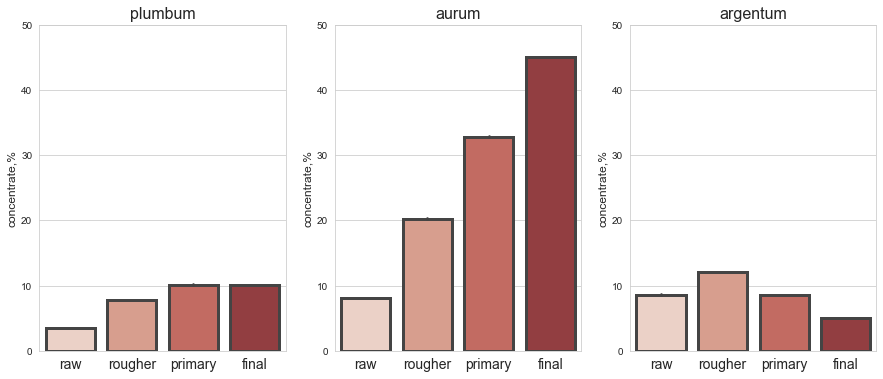

In [20]:
data_info = pd.DataFrame(features_input_concentrate, 
                         columns = ['sol', 'plumbum', 'aurum', 'argentum'], 
                         index   = ['raw', 'rougher', 'primary', 'final'])

plt.figure(figsize = (15,6))
sns.set_style('whitegrid')

for i, metal in enumerate(data_info.columns[1:]):
    
    plt.subplot(1, 3, i + 1)
    sns.barplot(data       = data_full[data_info[metal]],
                estimator  = np.median,
                palette    = 'Reds', 
                saturation = 0.5, 
                linewidth  = 3,
                edgecolor  = '#444444')
    
    plt.xticks(range(4),data_info.index, fontsize = 14)
    plt.title(metal, fontsize = 16)
    plt.ylabel('concentrate,%', fontsize = 12)
    plt.ylim(0,50)
    
plt.show(close = True)

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Как видно из представленной информации выше, концентрация свинца неюного увеличивается от фазы к фазе, но все равно остается очень низкой мене 10%. По-другому обстоят дела с концентрацией серебра, так после флотации концентрация увеличивается, но потом к финалу падает вдвое, хотя так же изначальная концентрация минимальна. Ну и конечно ярко выраженная динамика увеличения концентрации золота по фазам, это объясняется в принципе заточенный техпроцесс именно на этот метал, хотя показательным является тот факт, что даже на финальной стадии концентрация не достигает 50%
</p>

<h3 style="color:C0504D;">Суммарная концентрация металлов по фазам</h3>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Посмотрим на то, как распределяется суммарная концентрация металлов по фазам
</p>

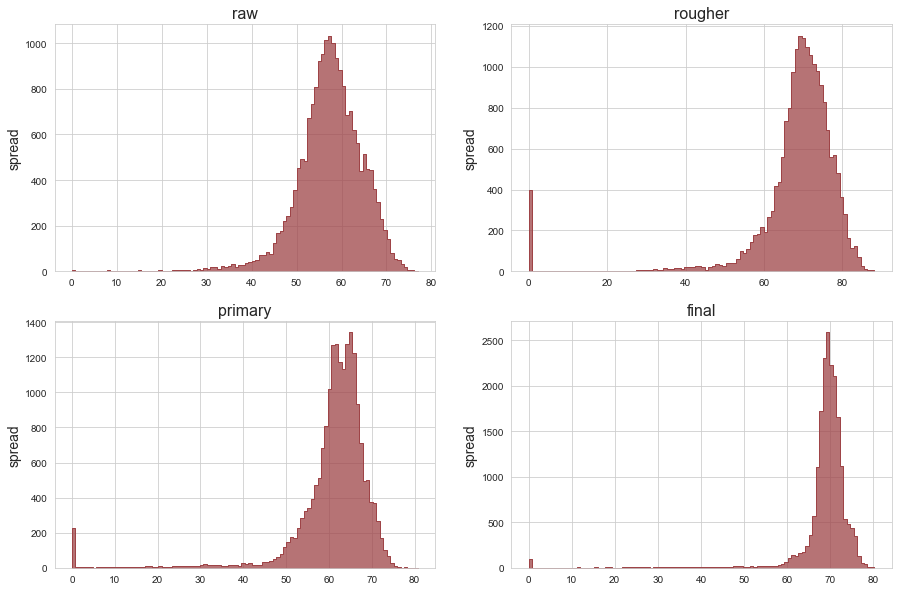

In [21]:
plt.figure(figsize = (15, 10))
sns.set_style('whitegrid')
x = ['raw', 'rougher', 'primary', 'final']

for i, stage in enumerate(features_input_concentrate):
    
    plt.subplot(2, 2, i + 1)
    sns.histplot(data = data_full[stage].sum(1),
                 color = '#9E4447',
                 element="step",
                 bins = 100)
    
    plt.title(f'{x[i]}', fontsize = 16);
    plt.ylabel('spread', fontsize = 14)
    
plt.show(close = True)

<div style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    <p>
        Как видно из представленной информации выше, концентрация металлов от фазы к фазе изменяет форму "колокола" распределения и становиться все выше и уже, т. е. это говорит о том, что отклонений становится все меньше и состав металлов на худится на требуемом уровне.
    </p>
    <p>
        В графике обнаружены аномалии в данных, очень сильно заметные на фазе флотации и первичной очистки в районе 0. Такого не может быть, потому что от фазы к фазе концентрации только увеличивается и уж тем более не может увеличиваться в районе 0. Необходимо убрать эти данные т. к. я считаю, что это ошибки либо в выгрузке данных, либо ошибки измерения концентрации.
    </p>
</div>

In [22]:
# задам условие что если сумма концентрации ниже 1
x = ['raw', 'rougher', 'primary', 'final']
data_info  = []

for i, summary in enumerate(features_input_concentrate):    
    data_info.append([x[i], len(data_full[data_full[summary].sum(1) < 1].index)]) 
    
pd.DataFrame(data_info, columns = ['stage', 'data_outliers'])\
            .style\
            .set_caption('Проверка количества выбросов в данных',)\
            .set_table_styles(styler)

,stage,data_outliers
0,raw,5
1,rougher,399
2,primary,228
3,final,99


In [23]:
for summary in features_input_concentrate:
    data_test  = data_test[data_full.loc[data_test.index][summary].sum(1) >= 1]
    data_train = data_train[data_train[summary].sum(1) >= 1]
    data_full  = data_full[data_full[summary].sum(1) >= 1] 

In [24]:
#проверю изменение состава выборок
for data in [data_train, data_test, data_full]:
    display(data.shape)

(13599, 86)

(5123, 52)

(18722, 86)

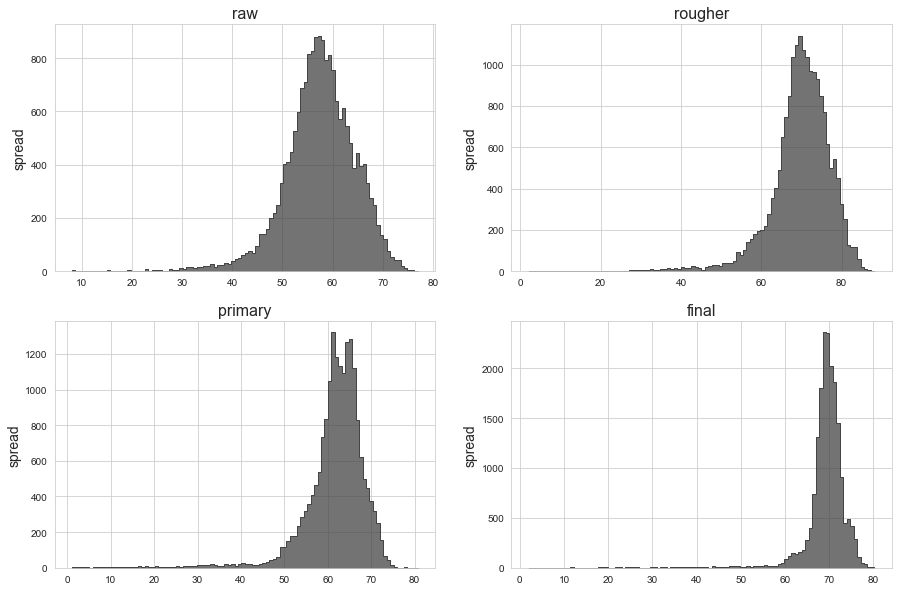

In [25]:
plt.figure(figsize = (15, 10))
sns.set_style('whitegrid')
x = ['raw', 'rougher', 'primary', 'final']

for i, stage in enumerate(features_input_concentrate):
    
    plt.subplot(2, 2, i + 1)
    sns.histplot(data = data_full[stage].sum(1),
                 color = '#444444',
                 element="step",
                 bins = 100)
    
    plt.title(f'{x[i]}', fontsize = 16);
    plt.ylabel('spread', fontsize = 14)
    
plt.show(close = True)

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Теперь графики выглядят лучше, без видимых выбросов
</p>

<h3 style="color:C0504D;">Распределение размеров гранул сырья</h3>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Необходимо проверить если распределения сильно отличаются друг от друга, оценка модели будет неправильной. Создам датафрейм для построения графика распределения
</p>

In [26]:
data_info = pd.DataFrame()
samples   = [data_train, data_test]
columns   = sorted(data_train.filter(like = 'size').columns, reverse = True)
stage     = ['train', 'test']

for i,data in enumerate(samples):
    
    for column in columns:
        
        data_info = data_info.append(\
                              data[column]\
                             .to_frame()\
                             .rename(columns = {column : 'feed_size'})\
                             .assign(stage = column.split('_')[0], sample = stage[i]))
        
data_info.reset_index().head(10)\
                       .style\
                       .format({'feed_size':'{:.2f}'})\
                       .set_caption('Таблица для построения распределения размера гранул',)\
                       .set_table_styles(styler)

,date,feed_size,stage,sample
0,2016-01-15 00:00:00,55.49,rougher,train
1,2016-01-15 01:00:00,57.28,rougher,train
2,2016-01-15 02:00:00,57.51,rougher,train
3,2016-01-15 03:00:00,57.79,rougher,train
4,2016-01-15 04:00:00,56.05,rougher,train
5,2016-01-15 05:00:00,57.47,rougher,train
6,2016-01-15 06:00:00,56.67,rougher,train
7,2016-01-15 07:00:00,56.73,rougher,train
8,2016-01-15 08:00:00,56.65,rougher,train
9,2016-01-15 09:00:00,58.51,rougher,train


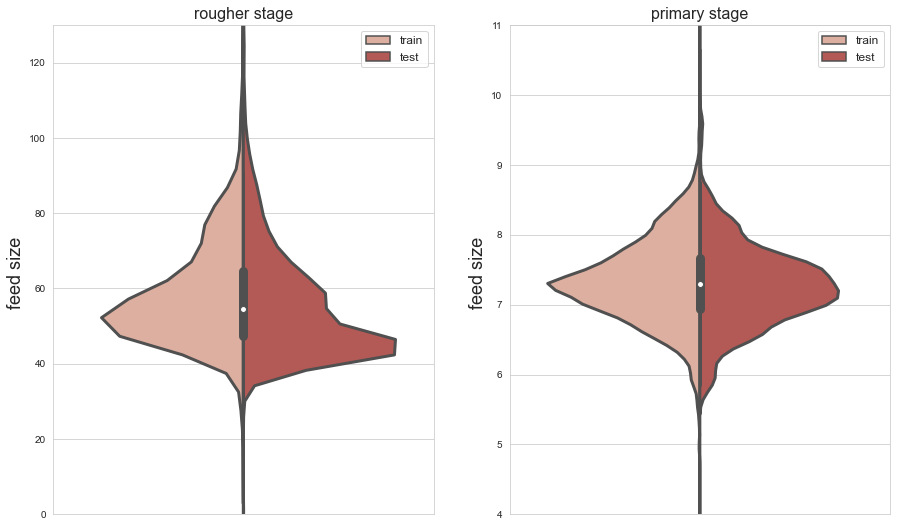

In [27]:
plt.figure(figsize=(15, 9))
plt.title('stage', fontsize=16)
sns.set_style('whitegrid')
y_lim =((0, 130), (4,11))

for i, j in enumerate(["rougher", "primary"]):
    
    plt.subplot(1, 2, i + 1)   
    sns.violinplot(x = "stage", 
                   y = "feed_size", 
                   hue = "sample",
                   data = data_info[data_info['stage'] == j],
                   palette    = 'Reds', 
                   saturation = 0.5, 
                   linewidth  = 3,
                   edgecolor  = '#444444',
                   split = True)
    
    plt.title(f'{j} stage', fontsize = 16);
    plt.ylim(y_lim[i])
    plt.ylabel('feed size ', fontsize = 18)
    plt.xlabel('')
    plt.xticks(range(1),[''])
    plt.legend(fontsize = 12)
    
plt.show()

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Информация по размерам гранул сырья есть для флотации и для первичной оценки, так же они разбиты на обучающую и тестовую, информация по их распределению представлена выше. Как видно распределение визуально выглядят симметрично, что говорит похожем соответствии выборок для обучения и тестирования. Немного хуже выглядит график для флотации, но не думаю, что это критично для построения модели
</p>

<div style="color:white; background-color:gray; border:solid #363636 1.5px; padding: 15px">
    <p>
        Выводы:
    </p>
    <ul>
        <li>Данные проанализированы;
        <li>Данные очищены от выбросов; 
        <li>Сделаны предварительные выводы;
        <li>Можно переходить поиску и обучению моделей.
    </ul>
</div>

<h2 style="color:C0504D;">Обучение модели и выбор лучшей</h2>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Основной задачей текущего проекта является прогноз эффективности обогащения на основании фактических данных. Необходимо подготовить модель, которая способна с высокой долей вероятности прогнозировать концентрацию золота. Целевой признак в моей задаче количественный, и для расчета необходимо учитывать два признака на стадии флотации и на финальном этапе данные которых находятся в признаках  <i><b>rougher_output_recovery, final_output_recovery</b></i>, соответственно буду использовать модель для регрессии <b>DecisionTreeRegressor, RandomForestRegressor, ExtraTreesRegressor, Lasso, LinearRegression</b> в рамках предсказания, где целевой признак концентрация золота. Подбор параметров буду производить с помощью <b>GridSearchCV</b>. Выбор модели на основании метрики с предельно большим значением <b>sMAPE</b>, которую необходимо создать самостоятельно. Ниже представлены формулы для расчета метрики
</p>


# $$fsMAPE = \frac{1}{N}\sum_{i=1}^{N}{\frac{|Y_i - \bar{Y}_i|}{(|Y_i|+|\bar{Y}_i|) / 2}} * 100\%$$

# $$fsMAPE = 25\%*sMAPE(rougher) + 75\%*sMAPE(final)$$

<h3 style="color:C0504D;">Подготовка метрики sMAPE</h3>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    На основании формул указаных выше, составляю функцию для расчета метрики и передаю ее с помощью метода <b>make_scorer</b> как кастомный скорер для оценки модели
</p>

In [28]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred): 
    
    def smape(target,predict): 
        return (1 / len(target)) * sum(np.abs(target - predict)/ ((np.abs(target) + np.abs(predict)) / 2)) * 100
    
    y_true = np.array(y_true)
    
    smape_rougher = smape(y_true[:,1], y_pred[:,1])
    
    smape_final   = smape(y_true[:,0], y_pred[:,0])
    
    return 0.25 * smape_rougher + 0.75 * smape_final

In [29]:
SMAPE = make_scorer(symmetric_mean_absolute_percentage_error, greater_is_better = False)

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Разделю выборку на признаки и целевой признак, т.к. признаки имеют тип данных float и различаются по масштабу, сразу проведу масштабирование этих признаков с помощью <b>StandardScaler()</b>
</p>

In [30]:
features_train = data_train[data_test.columns]
target_train   = data_train.filter(like = 'recovery')

In [31]:
scaler = StandardScaler()
scaler.fit(features_train)    
features_train = scaler.transform(features_train)

<h3 style="color:C0504D;">Модели с базовыми параметрами</h3>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Перебирать все модели с параметрами я буду с помощью <b>GridSearchCV</b>, для этого подготовлю два списка с моделями <i><b>regressors</b></i> и с гиперпараметрами для этих моделей <i><b>parameters</b></i>. Для начала я решил проверить все модели на базовых гиперпараметрах, чтобы в дальнейшем можно было увидеть динамику изменения качества моделей, для оценки качества моделей выбираю 5 фолдов для кросс-валидации в настройках Grid
</p>

In [32]:
regressors = [LinearRegression(),
              Lasso(random_state = RANDOM),
              DecisionTreeRegressor(random_state = RANDOM),
              ExtraTreesRegressor(random_state = RANDOM),
              RandomForestRegressor(random_state = RANDOM)]

In [33]:
parameters = [{}] * len(regressors)

In [34]:
scores_base = [['Linear Regression', -10.06594012740744, 0.15321850776672363, {}],
               ['Lasso', -8.625199356073605, 0.3419657230377197, {}],
               ['Decision Tree Regressor', -14.533426202714091, 0.8597116947174073, {}],
               ['Extra Trees Regressor', -8.933783279894774, 10.044495773315429, {}],
               ['Random Forest Regressor', -9.155858598610378, 48.54978194236755, {}]]

In [35]:
pd.DataFrame(data    = scores_base, 
             columns = ['model', 'smape', 'mean_fit_time', 'parameters'])\
            .sort_values('smape', ascending = False)\
            .reset_index(drop = True)\
            .style\
            .format({'smape':'{:.2f}', 'mean_fit_time' : '{:,.2f}s'})\
            .set_caption(f'Результаты моделей на базовых параметрах',)\
            .set_table_styles(styler)

,model,smape,mean_fit_time,parameters
0,Lasso,-8.63,0.34s,{}
1,Extra Trees Regressor,-8.93,10.04s,{}
2,Random Forest Regressor,-9.16,48.55s,{}
3,Linear Regression,-10.07,0.15s,{}
4,Decision Tree Regressor,-14.53,0.86s,{}


<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Как видно из сводных данных выше, на базовых настройках лучший результат и по качеству метрики и по скорости расчета у модели <b>Lasso</b>, недалеко от нее модель <b>Extra Trees Regressor</b>, но сильно уступает по времени обработки, что может быть критично для больших массивов данных
</p>

<h3 style="color:C0504D;">Подбор гиперпараметров</h3>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    брать параметры для моделей и на основании показателей качества моделей выберу лучшую
</p>

In [36]:
parameters = [{                                           },
              
              {'selection'    : ['cyclic', 'random'],
               'max_iter'     : [1000]}, 
              
              {'criterion'    : ['friedman_mse', 'poisson'],
               'max_depth'    : list(range(1,11))},
              
              {'n_estimators' : list(range(10,101,10)),
               'max_depth'    : list(range(1,11))},
              
              {'n_estimators' : list(range(10,101,10)),
               'max_depth'    : list(range(1,11))}        ]

In [37]:
scores_param = \
    [['Linear Regression', -10.065940127407446, 1.299419641494751, {}],
     ['Lasso', -8.625144515400546, 6.498683214187622,{'max_iter': 1000, 'selection': 'random'}],
     ['Decision Tree Regressor', -8.88587560791752, 38.834084272384644,{'criterion': 'friedman_mse', 'max_depth': 1}],
     ['Extra Trees Regressor', -8.445925052089708, 444.099880695343, {'max_depth': 5, 'n_estimators': 70}],
     ['Random Forest Regressor', -8.719239403417578, 5246.102777481079, {'max_depth': 4, 'n_estimators': 80}]]

In [38]:
pd.DataFrame(data    = scores_param, 
             columns = ['model', 'smape', 'time', 'parameters'])\
            .sort_values('smape', ascending = False)\
            .reset_index(drop = True)\
            .style\
            .format({'smape':'{:.2f}', 'time' : '{:,.2f}s'})\
            .set_caption(f'Результаты поиска лучшей модели с подбором гиперпараметров',)\
            .set_table_styles(styler)

,model,smape,time,parameters
0,Extra Trees Regressor,-8.45,444.10s,"{'max_depth': 5, 'n_estimators': 70}"
1,Lasso,-8.63,6.50s,"{'max_iter': 1000, 'selection': 'random'}"
2,Random Forest Regressor,-8.72,"5,246.10s","{'max_depth': 4, 'n_estimators': 80}"
3,Decision Tree Regressor,-8.89,38.83s,"{'criterion': 'friedman_mse', 'max_depth': 1}"
4,Linear Regression,-10.07,1.30s,{}


<div style="color:white; background-color:gray; border:solid #363636 1.5px; padding: 15px">
    <p>
        Выводы:
    </p>
    <ul>
        Как видно из сводных данных выше, двойку лучших моделей также занимают те же самые модели, но лидер поменялся, на первое место вышла модель <b>Extra Trees Regressor</b> с лучшими показателями по качеству метрики, но, как и на предыдущем этапе значительно уступает по скорости работы алгоритма модели <b>Lasso</b>. На данном этапе необходимо выбрать лучшую модель, но выбор неочевиден, т. к. качество по метрики модели не сильно отличаются, а вот по скорости решения задачи лидер ярко выражен. Но есть и неоднозначные показатели дерево улучшило свои показатели с предыдущего этапа, хотя и не сильно, а вот Lasso осталось на том же уровне, я предлагаю выбрать две модели на следующий этап там уже финально выбрать модель на тестовом наборе, где надеюсь будет очевиден лидер и качество моделей будет различаться в большей степени
    </ul>
</div>

<h2 style="color:C0504D;">Тестирование лучшей модели</h2>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Тестирование модели буду проводить на выборке <b>data_test</b>, так же предварительно решив вопрос с масштабирование признаков. Для моделей указываю лучшие параметры с предыдущего этапа
</p>

In [39]:
features_test = scaler.transform(data_test)

<h3 style="color:C0504D;">Тестирование моделей</h3>

In [40]:
models = [Lasso(random_state = RANDOM, max_iter = 1000, selection = 'random'),
          ExtraTreesRegressor(random_state = RANDOM, max_depth = 5, n_estimators = 70)]

In [41]:
scores_final = []
data_info    = pd.DataFrame()
x = ['Lasso', 'Extra Trees Regressor']
for i, model in enumerate(models):  
    
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    target_test = data_full.loc[data_test.index].filter(like = 'recovery')
    score       = symmetric_mean_absolute_percentage_error(target_test, predictions)
    
    data_info = data_info.append(pd.DataFrame(predictions).assign(model  = x[i], sample = 'predict'))
    
    data_info = data_info.append(target_test.rename(columns = {'final_output_recovery' : 0, 'rougher_output_recovery' : 1})\
                                            .assign(model = x[i], sample = 'true'))
    
    scores_final.append([' '.join(re.sub(r'([A-Z])', r' \1', str(model).split('(')[0]).split()), -score])
    
data_info = data_info.rename(columns = {0: 'final', 1 :'rougher'}).reset_index(drop = True)

In [42]:
pd.DataFrame(data = np.array(scores_base)[:,:2],
             columns = ['model', 'smape_base'])\
            .assign(smape_param = np.array(scores_param)[:,1])\
            .merge(pd.DataFrame(scores_final, columns = ['model', 'smape_final']), on = 'model', how='outer')\
            .sort_values('smape_final', ascending = False)\
            .fillna(0)\
            .reset_index(drop = True)\
            .style\
            .format({'smape_base':'{:.2f}', 'smape_param':'{:.2f}', 'smape_final':'{:.2f}'})\
            .set_caption(f'Финальные разультаты подготовки модели',)\
            .set_table_styles(styler)

,model,smape_base,smape_param,smape_final
0,Lasso,-8.63,-8.63,-6.36
1,Extra Trees Regressor,-8.93,-8.45,-6.72
2,Linear Regression,-10.07,-10.07,0.00
3,Decision Tree Regressor,-14.53,-8.89,0.00
4,Random Forest Regressor,-9.16,-8.72,0.00


<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Показатели качества моделей улучшилось на тестовой выборке, но вот разница в метрике моделей осталась на том же уровне. Можно сделать выбор на основании статистики показателей, но я бы предварительно хотел визуально провести осмотр предсказаний моделей, возможно там будет ответ на выбор модели.
</p>

<h3 style="color:C0504D;">Сравнение распределения предсказаний моделей</h3>

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Предварительно создам датафрейм для построения графиков
</p>

In [43]:
data_info.head(10).style\
                  .format({'final':'{:.2f}', 'rougher':'{:.2f}'})\
                  .set_caption(f'Информация по моделям для каждого этапа',)\
                  .set_table_styles(styler)

,final,rougher,model,sample
0,71.43,88.55,Lasso,predict
1,71.16,88.39,Lasso,predict
2,71.18,88.52,Lasso,predict
3,70.79,87.79,Lasso,predict
4,69.59,86.59,Lasso,predict
5,67.49,84.71,Lasso,predict
6,66.52,83.90,Lasso,predict
7,66.31,83.76,Lasso,predict
8,66.23,83.79,Lasso,predict
9,65.59,83.24,Lasso,predict


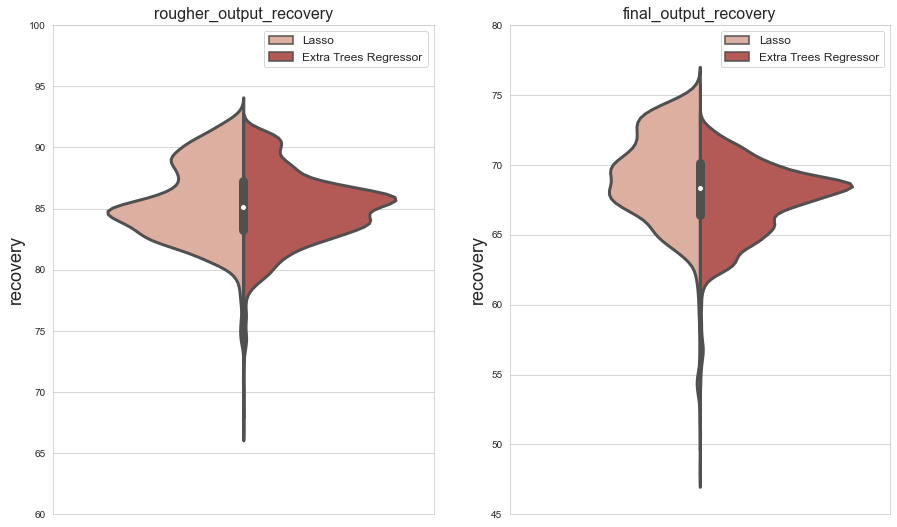

In [44]:
plt.figure(figsize=(15, 9))
plt.title('stage', fontsize=16)
sns.set_style('whitegrid')
y_lim =((60, 100), (45, 80))

for i, j in enumerate(['rougher', 'final']):
    
    plt.subplot(1, 2, i + 1)   
    sns.violinplot(x = "sample", 
                   y = j, 
                   hue = "model",
                   data = data_info[data_info['sample'] == 'predict'],
                   palette    = 'Reds', 
                   saturation = 0.5, 
                   linewidth  = 3,
                   edgecolor  = '#444444',
                   split = True)
    
    plt.title(f'{j}_output_recovery', fontsize = 16);
    plt.ylim(y_lim[i])
    plt.ylabel('recovery', fontsize = 18)
    plt.xlabel('')
    plt.xticks(range(1),[''])
    plt.legend(fontsize = 12)
    
plt.show()

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Из графиков распределения предсказаний видно, что распределение предсказания и для флотации и финального этапа имеет форму не правильного распределения, распределения имеют сильную кривизну хотя в основном сосредоточены в одной области среднего значения. А вот для финальной концентрации выборки уже разнятся сильнее, дерево сильно усредняет данные, в то время как лассо старается определить значение показателя, как и в целевом распределении далее можно сравнить распределение моделей в сравнении с целевыми признаками.
</p>

<h3 style="color:C0504D;">Сравнение предсказаний моделей с целевым признаком</h3>

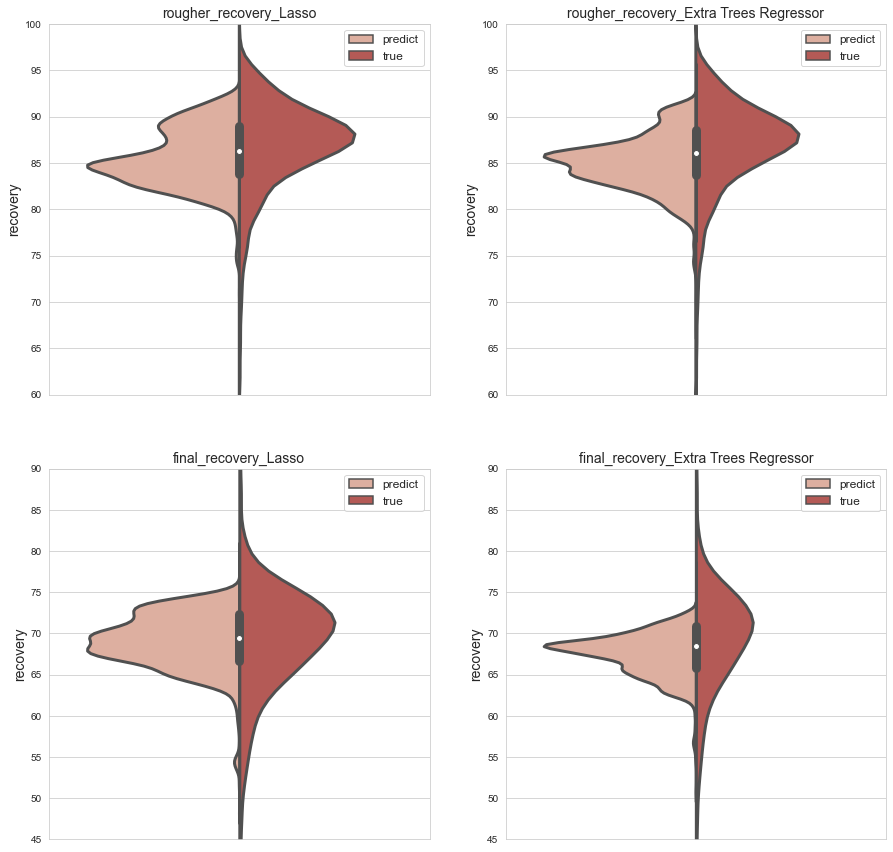

In [45]:
plt.figure(figsize=(15, 15))
plt.title('stage', fontsize=16)
sns.set_style('whitegrid')
y_lim =((60, 100), (45, 90))
count = 0

for i, j in enumerate(['rougher', 'final']):
    
    for model in ['Lasso', 'Extra Trees Regressor']:
        count += 1
        plt.subplot(2, 2, count)   
        sns.violinplot(x = "model", 
                       y = j, 
                       hue = "sample",
                       data = data_info[data_info['model'] == model],
                       palette    = 'Reds', 
                       saturation = 0.5, 
                       linewidth  = 3,
                       edgecolor  = '#444444',
                       split = True)

        plt.title(f'{j}_recovery_{model}', fontsize = 14);
        plt.ylim(y_lim[i])
        plt.ylabel('recovery', fontsize = 14)
        plt.xlabel('')
        plt.xticks(range(1),[''])
        plt.legend(fontsize = 12)
    
plt.show()

<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Из графиков видно как обе модели стараются сильно усреднить показатели предсказания что в итоге сильно заметно по форме распределения, так же заметен потолок в который упирается предсказания моделей, но Lasso именно на финальной метрике все равно выглядит лучше показывая более правильное распределение, а так как в метрике 75% именно финального показателя за счет этого качество предсказания выше, хотя я думаю что исходя из визуального осмотра моделей при проверке на DummyRegressor показатели будут не намного хуже, скорее всего это особенность данного набора данных которые имеют много характеристик, которые по отдельности вносят незначительный весь при определении конечного результата и в то же время само распределение фактических показателей не имеет большого разброса, что тоже обусловлено спецификой производство где идет борьба за каждый процент концентрации золота. Перед окончательными выводами финально проверю модель на DummyRegressor
</p>

<h3 style="color:C0504D;">Проверка на адекватность</h3>

In [46]:
model = DummyRegressor(strategy = 'mean')
model.fit(features_train, target_train)
predict_dummy = model.predict(features_test)
score_dummy   = symmetric_mean_absolute_percentage_error(target_test, predict_dummy)
print(f'показатель SMAPE на модели DummyRegressor: {-score_dummy:.2f}')

показатель SMAPE на модели DummyRegressor: -7.78


<p style="color: #363636; background-color:whitesmoke; border:solid #363636 1.5px; padding: 15px">
    Предыдущие выводы были верными и показатели на DummyRegressor не сильно отличаются от показателей Lasso 7,78 против 7,14
</p>

<div style="color:white; background-color:gray; border:solid #363636 1.5px; padding: 15px">
    <p>
        Выводы:
    </p>
    <ul>
        <li>Предоставленные данные были проанализированы и подготовлены, для дальнейшей работы. В данных были обнаружены
            некоторые недочеты, о которых было написано выше, можно остановиться только на одном моменте. В данных
            присутствовали аномальные значения, которые предположительно появились в процессе замеров показателей,
            хотелось бы обратить внимание на этом моменте, т.к. возможно это разовый сбой, а возможно закономерные
            проблемы в техпроцессе.
        <li>Задача по подбору модели была выполнена, для этого в несколько этапов была произведена подготовка и проверка
            моделей на представленных данных, в итоге выбор был не совсем очевиден модели показывали ошибку в
            предсказаниях на уровне 7% но с огромной разницей во времени работы алгоритма, что для больших массивов
            данных может быть критично. Что по качеству модели то однозначно выбор должен быть в сторону модели
            <b>Lasso</b> с гиперпараметрами <b>max_iter = 1000, selection = 'random'</b>, что было подтверждено на
            графиках распределения, где распределение у модели дерева в значительной степени выглядит хуже модели Lasso,
            где последняя имеет более правильную форму. Но модель ExtraTreesRegressor можно использовать как
            альтернативный вариант.
            Как видно из сводных данных выше, двойку лучших моделей также занимают те же самые модели, но лидер
            поменялся, на первое место вышла модель <b>Extra Trees Regressor</b> с лучшими показателями по качеству
            метрики, но, как и на предыдущем этапе значительно уступает по скорости работы алгоритма модели
            <b>Lasso</b>. На данном этапе необходимо выбрать лучшую модель, но выбор неочевиден, т. к. качество по
            метрики модели не сильно отличаются, а вот по скорости решения задачи лидер ярко выражен. Но есть и
            неоднозначные показатели дерево улучшило свои показатели с предыдущего этапа, хотя и не сильно, а вот Lasso
            осталось на том же уровне, я предлагаю выбрать две модели на следующий этап там уже финально выбрать модель
            на тестовом наборе, где надеюсь будет очевиден лидер и качество моделей будет различаться в большей степени
    </ul>
    <p>
        Итог выбора:
    </p>
    <li>модель Lasso(max_iter = 1000, selection = 'random')
        <br>
        <p>
            альтернативный вариант для экспресс-оценки:
        </p>
    <li>модель ExtraTreesRegressor(max_depth = 5, n_estimators = 70)
</div>